# Data evaluation hands-on


**First you need to get the raw data from:**

STEFFENS Paul; DELLEA Greta; DENG Yue; DIETL Christopher; DJURADO David; GAMBINO Marianna; HEPTING Matthias; INKINEN JUHO; JAFARI Atefeh; LEFRANCOIS Emilie; LOPES SELVATI Ana Carolina; PANAHI Hamed; PEDERSEN Martin Nors; PRADIP Ramu; RANIERI Umbertoluca; ROSSI Matteo; SCHATTE Sarah; STANA Markus; TIMOSENKO Janis; VONESHEN David and ZBIRI Mohamed. (2014). HSC17 Hercules practical course. Institut Laue-Langevin (ILL) [doi:10.5291/ILL-DATA.TEST-2385](https://doi.ill.fr/10.5291/ILL-DATA.TEST-2385)

Actually ILL dataportal is not very friendly for getting all data programatically. Just select next cell and press SHIFT + ENTER. Then enter username and password for ill.eu

In [1]:
# import libraries i will need
# for downloading files from itnernet
import requests
# for parsing html data
from bs4 import BeautifulSoup
# for creating folder
import os
# for entering password
import getpass

user = input("Enter username for data.ill.fr: ")
pw = getpass.getpass("Enter password for data.ill.fr: ")

payload = {
    'username': user,
    'password': pw
}   
data_url = 'https://data.ill.eu/proposal/getfile?download=1&file=142/in3/exp_TEST-2385/rawdata/%06d'

if not os.path.exists('rawdata'):
    os.mkdir('rawdata')

with requests.Session() as sess:
    res = sess.get('http://data.ill.fr/')
    signin = BeautifulSoup(res._content, 'html.parser')
    url = signin.find('form', id='kc-form-login')['action']
    res = sess.post(url, data=payload)
    for numor in range(84860, 84906):
        r = sess.get(data_url % numor, allow_redirects=True)
        open('rawdata/%06d' % numor, 'wb').write(r.content)

Enter username for data.ill.fr: 
Enter password for data.ill.fr: ········


## First task

Figure out last datafile measured and add its number instead of ???

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


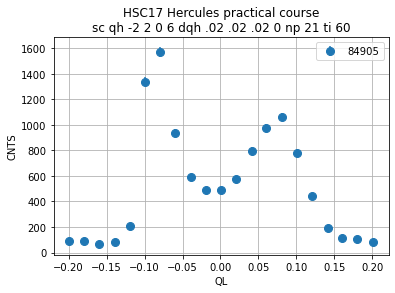

In [2]:
from ufit.lab import *

# set a template, so that data can be referenced by number only
set_datatemplate('%06d')
# read one dataset from a file, with given X and Y columns
data = read_data(84905, 'QL', 'CNTS')

data.plot()

## Second task

You can try to run the follwing code - data are clearly not one peak.

 - Add second peak to the model (simply with + sign)

Both peaks should be symetric along 0, in order to fix that, set fixed position for the second peak `pos='p1_pos'`

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Fit results for 84905
--------------------------------------------------------------------------------
bkgd            =     69.618 +/-     27.683
p1_pos          =   0.070693 +/-  0.0025658
p1_ampl         =     969.19 +/-     126.86
p1_fwhm         =   0.092632 +/-   0.010257
p2_pos          =  -0.070693 +/-          0 (fixed: -p1_pos)
p2_ampl         =     1265.3 +/-      174.3
p2_fwhm         =   0.061899 +/-  0.0065881
chi^2/NDF       =       43.9


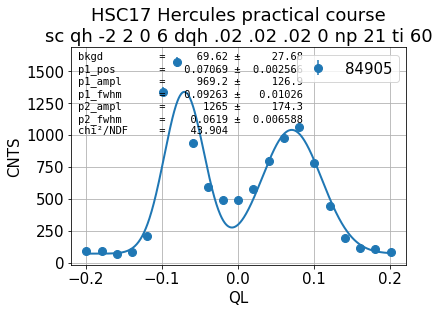

In [16]:
# create a model of a simple Gaussian peak with given initial guess
model = Background() + Gauss('p1', pos=0.06, ampl=100, fwhm=0.1) +  Gauss('p2', pos="-p1_pos", ampl=100, fwhm=0.1)

# fit the model, then print and plot the result
result = model.fit(data)
result.printout()
result.plot()
show()

## Third task

Play with font size and labels until you are happy. It will be saved to pdf.

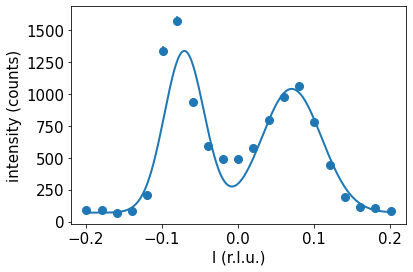

In [17]:
rcParams.update({'font.size': 15})
result.plot(params=False)
legend().set_visible(False)
title("")
xlabel("l (r.l.u.)")
ylabel("intensity (counts)")
grid(False)
savefig("energy-scan.pdf", bbox_inches='tight')
show()

## Fourth task

Add conversion from mev to cm-1

In [18]:
energy = result.data.meta["EN"]
energy = energy * 8.065  #1 meV  =  8.065 cm-1
print(energy)

48.189988


In [19]:
result.data.meta

{'instrument': 'in3',
 'experiment': 'test-2385',
 'filenumber': 84905,
 'title': 'HSC17 Hercules practical course',
 'subtitle': 'sc qh -2 2 0 6 dqh .02 .02 .02 0 np 21 ti 60',
 'GONIO': 0.0,
 'DM': 3.355,
 'DA': 3.355,
 'KFIX': 2.66325,
 'SM': -1.0,
 'SS': -1.0,
 'SA': 1.0,
 'FX': 2.0,
 'ALF1': 600.0,
 'ALF2': 600.0,
 'ALF3': 600.0,
 'ALF4': 600.0,
 'BET1': 600.0,
 'BET2': 600.0,
 'BET3': 600.0,
 'BET4': 600.0,
 'ETAM': 35.0,
 'ETAA': 35.0,
 'AS': 5.431,
 'BS': 5.431,
 'CS': 5.431,
 'AA': 90.0,
 'BB': 90.0,
 'CC': 90.0,
 'ETAS': 1.0,
 'AX': 1.0,
 'AY': 1.0,
 'AZ': 1.0,
 'BX': 1.0,
 'BY': -1.0,
 'BZ': 0.0,
 'TI': 60.0,
 'TT': 1.6023333333333334,
 'RT': 1.75,
 'REACTOR': 0.0,
 'QH': -1.9996809523809527,
 'QK': 2.000914285714286,
 'QL': 0.000619047619047621,
 'EN': 5.9752,
 'M1': 1279129.3333333333,
 'M2': 0.0,
 'TIME': 60.0,
 'CNTS': 527.0,
 'A3': -41.214285714285715,
 'A4': -68.00904761904762,
 'environment': ['T = 1.602 K'],
 'hkle': array([[-2.1996e+00,  1.8006e+00, -1.9950e-01,  5.

## Plot the results

Just evaluate the next cell

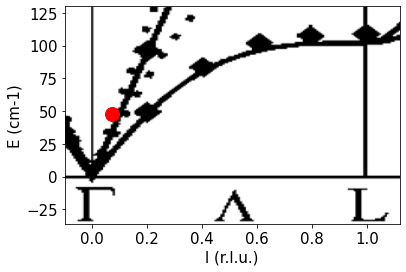

In [20]:
img = imread("phonon.png")
fig, ax = subplots()
errorbar([result.paramvalues['p1_pos']], [energy], xerr=result.paramerrors['p1_pos'], fmt='ro', ms = 14)
ax.imshow(img, extent=[-0.1, 1.12, -36, 130], aspect='auto')
savefig("dispersion.pdf", bbox_inches='tight')
xlabel("l (r.l.u.)")
ylabel("E (cm-1)")
show()